# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [ ]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

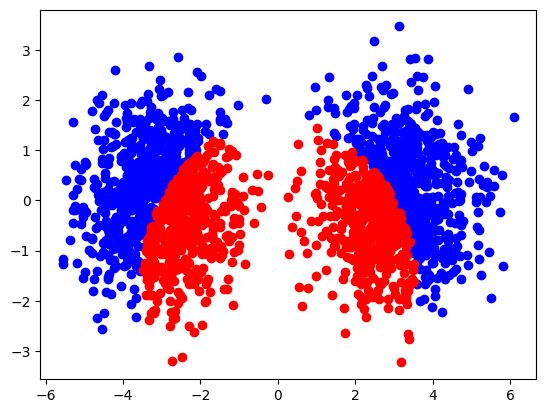

In [ ]:
# Visualize the data
# TODO
plt.scatter(data[labels==1,0],data[labels==1,1],c='b')
plt.scatter(data[labels==0,0],data[labels==0,1],c='r')
plt.show()

Linear models will not be able to seperate the classes well since linear models have linear dicision boundry. Here the ideal decision boundry is clearly not linear.

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [ ]:
class Expert(nn.Module):
    def __init__(self, input_dim):
        super(Expert, self).__init__()
        self.input_dim = input_dim
        self.network = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.network(x)

## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [ ]:
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super(GatingNetwork, self).__init__()
        self.input_dim = input_dim
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_experts),
            nn.Softmax(dim=1)
            )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.network(x)


## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [ ]:
class MixtureOfExperts(nn.Module):
    def __init__(self, input_size, num_experts=2):
        super(MixtureOfExperts, self).__init__()
        self.expert_models = nn.ModuleList([Expert(input_size) for _ in range(num_experts)])
        self.gating_model = GatingNetwork(input_size, num_experts)

    def forward(self, x):
        gate_values = self.gating_model(x)
        expert_outputs = torch.stack([expert(x) for expert in self.expert_models], dim=2)
        gate_values = gate_values.unsqueeze(1).expand_as(expert_outputs)
        output = F.sigmoid(torch.sum(gate_values * expert_outputs, dim=2))
        return output


## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [ ]:
# Define the model, loss, and optimizer
model = MixtureOfExperts(2)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    output = model(data_tensor)
    loss = criterion(output, labels_tensor)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Decay the learning rate
    scheduler.step()
    # Print out the loss and accuracy

    pred = (output > 0.5).float()
    acc = (pred == labels_tensor).float().mean()
    if epoch % 10 == 0:
      print(str(epoch)+'th epoch, loss is ', loss.item())
      print(str(epoch)+'th epoch, accuracy is ', acc.item())


0th epoch, loss is  0.7145191431045532
0th epoch, accuracy is  0.41999998688697815
10th epoch, loss is  0.29658132791519165
10th epoch, accuracy is  0.878000020980835
20th epoch, loss is  0.15529309213161469
20th epoch, accuracy is  0.9340000152587891
30th epoch, loss is  0.09988955408334732
30th epoch, accuracy is  0.968999981880188
40th epoch, loss is  0.08921100944280624
40th epoch, accuracy is  0.9745000004768372
50th epoch, loss is  0.08036452531814575
50th epoch, accuracy is  0.9745000004768372
60th epoch, loss is  0.07626097649335861
60th epoch, accuracy is  0.9760000109672546
70th epoch, loss is  0.07419734448194504
70th epoch, accuracy is  0.9760000109672546
80th epoch, loss is  0.0728161633014679
80th epoch, accuracy is  0.9760000109672546
90th epoch, loss is  0.07189160585403442
90th epoch, accuracy is  0.9754999876022339


## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

In [ ]:
def plot_decision_boundary(model,data,labels,axis,title):
  x = torch.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100))
  y = torch.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100))
  data_total = torch.cartesian_prod(x, y)
  output = model(data_total)
  x, y = torch.meshgrid(x, y)
  pred = (output > 0.5).float().view(len(x),-1)
  from matplotlib.colors import ListedColormap
  import matplotlib.pyplot as plt
  plt.contourf(x, y, pred, linewidth=5)
  plt.scatter(data[labels==1,0],data[labels==1,1],c='g', alpha=0.3)
  plt.scatter(data[labels==0,0],data[labels==0,1],c='r',alpha=0.3)
  plt.title(title)
  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-8-c5ab3e3f79b2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


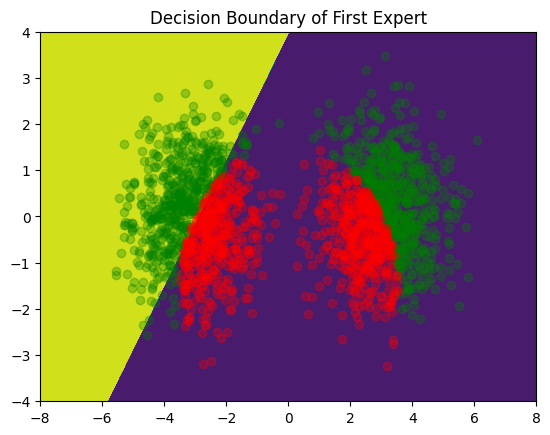

In [ ]:
plot_decision_boundary(model.expert_models[0],data,labels,[-8,8,-4,4],'Decision Boundary of First Expert')

<ipython-input-8-c5ab3e3f79b2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


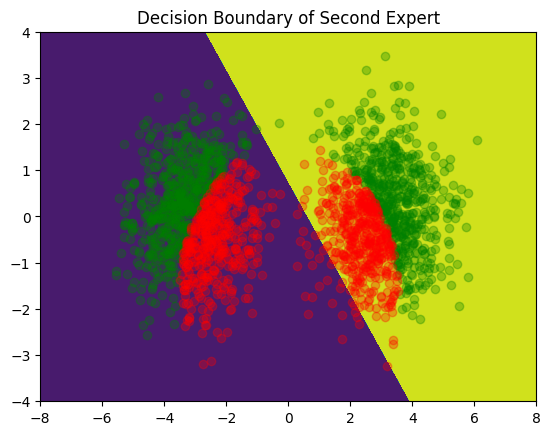

In [ ]:
plot_decision_boundary(model.expert_models[1],data,labels,[-8,8,-4,4],'Decision Boundary of Second Expert')

<ipython-input-8-c5ab3e3f79b2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


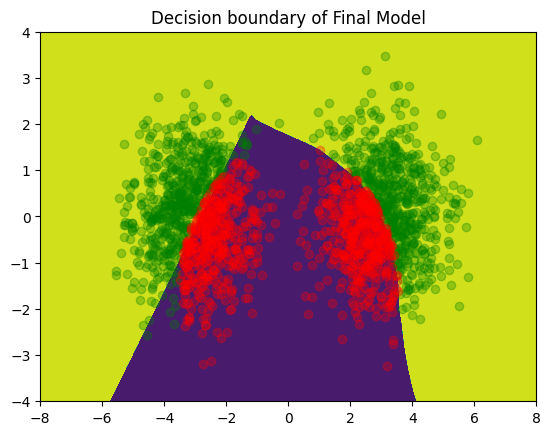

In [ ]:
plot_decision_boundary(model,data,labels,[-8,8,-4,4],'Decision boundary of Final Model')

<ipython-input-12-29cf9284859e>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


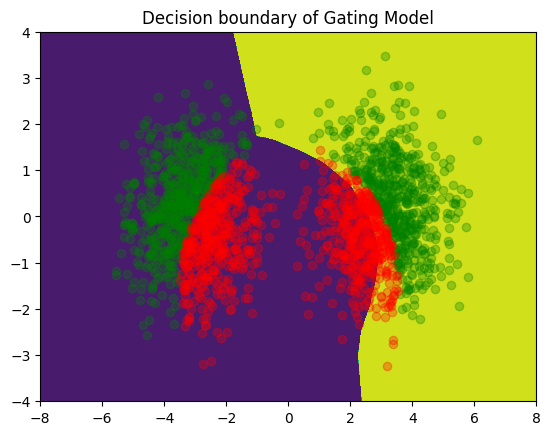

In [ ]:
def gate_decision_boundary(model,data,labels,axis,title):
  x = torch.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100))
  y = torch.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100))
  data_total = torch.cartesian_prod(x, y)
  output = model(data_total)
  x, y = torch.meshgrid(x, y)
  _, pred = torch.max(output,1)
  pred = pred.view(len(x),-1)
  from matplotlib.colors import ListedColormap
  import matplotlib.pyplot as plt
  plt.contourf(x, y, pred, linewidth=5)
  plt.scatter(data[labels==1,0],data[labels==1,1],c='g',alpha=0.3)
  plt.scatter(data[labels==0,0],data[labels==0,1],c='r',alpha=0.3)
  plt.title(title)
  plt.show()

gate_decision_boundary(model.gating_model,data,labels,[-8,8,-4,4],'Decision boundary of Gating Model')

Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?

I found that the first expert mainly deal with the seperation of points on the left hand side of the graph while the second expert focus on the right hand side. Basically the gate tried to seperate the right hand side well and then use the experts to do the seperation so that the prediction accuracy is improved.

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)



In [ ]:
# Define the model, loss, and optimizer
model_2 = MixtureOfExperts(2,5)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.1)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    output = model_2(data_tensor)
    loss = criterion(output, labels_tensor)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Decay the learning rate
    scheduler.step()
    # Print out the loss and accuracy

    pred = (output > 0.5).float()
    acc = (pred == labels_tensor).float().mean()
    if epoch % 10 == 0:
      print(str(epoch)+'th epoch, loss is ', loss.item())
      print(str(epoch)+'th epoch, accuracy is ', acc.item())

0th epoch, loss is  0.739827036857605
0th epoch, accuracy is  0.5049999952316284
10th epoch, loss is  0.28498467803001404
10th epoch, accuracy is  0.8840000033378601
20th epoch, loss is  0.11548386514186859
20th epoch, accuracy is  0.9819999933242798
30th epoch, loss is  0.07409656047821045
30th epoch, accuracy is  0.9860000014305115
40th epoch, loss is  0.054477181285619736
40th epoch, accuracy is  0.9865000247955322
50th epoch, loss is  0.03883156180381775
50th epoch, accuracy is  0.9944999814033508
60th epoch, loss is  0.030176568776369095
60th epoch, accuracy is  0.9944999814033508
70th epoch, loss is  0.02476368099451065
70th epoch, accuracy is  0.9975000023841858
80th epoch, loss is  0.022609733045101166
80th epoch, accuracy is  0.9950000047683716
90th epoch, loss is  0.02038579434156418
90th epoch, accuracy is  0.996999979019165


<ipython-input-8-c5ab3e3f79b2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


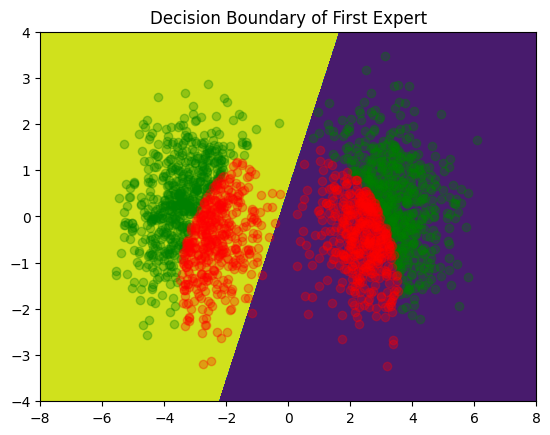

In [ ]:
plot_decision_boundary(model_2.expert_models[0],data,labels,[-8,8,-4,4],'Decision Boundary of First Expert')

<ipython-input-8-c5ab3e3f79b2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


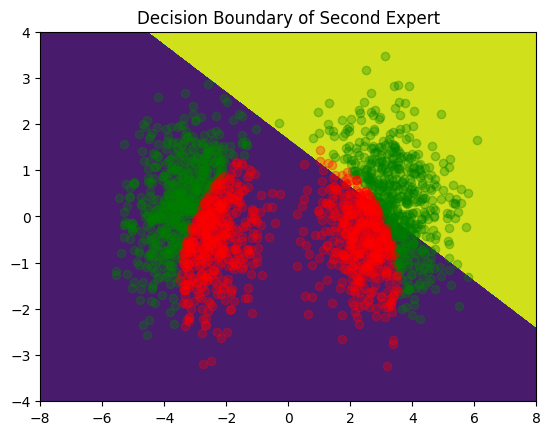

In [ ]:
plot_decision_boundary(model_2.expert_models[1],data,labels,[-8,8,-4,4],'Decision Boundary of Second Expert')

<ipython-input-8-c5ab3e3f79b2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


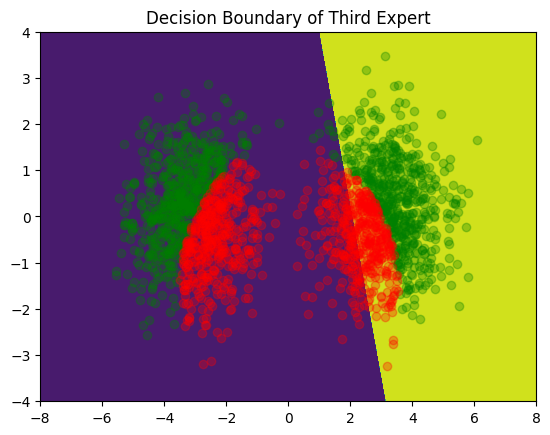

In [ ]:
plot_decision_boundary(model_2.expert_models[2],data,labels,[-8,8,-4,4],'Decision Boundary of Third Expert')

<ipython-input-8-c5ab3e3f79b2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


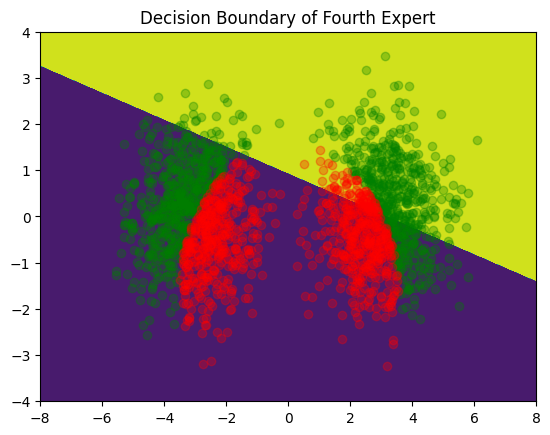

In [ ]:
plot_decision_boundary(model_2.expert_models[3],data,labels,[-8,8,-4,4],'Decision Boundary of Fourth Expert')

<ipython-input-8-c5ab3e3f79b2>:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


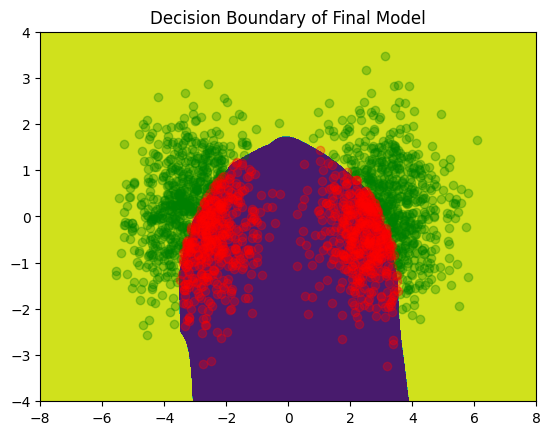

In [ ]:
plot_decision_boundary(model_2,data,labels,[-8,8,-4,4],'Decision Boundary of Final Model')

<ipython-input-12-29cf9284859e>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x, y, pred, linewidth=5)


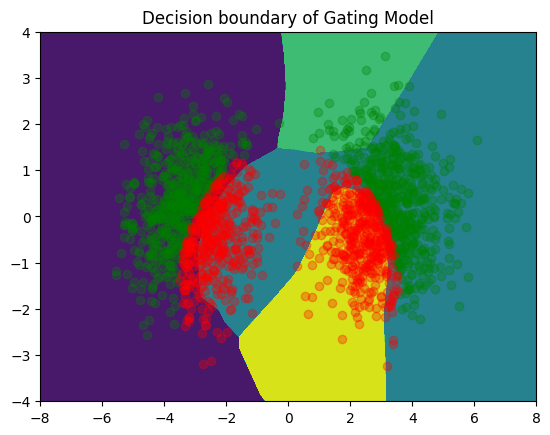

In [ ]:
gate_decision_boundary(model_2.gating_model,data,labels,[-8,8,-4,4],'Decision boundary of Gating Model')

We can see that as we increase the number of experts to 5, the experts would have more detailed task to do (experts become more expert in their domain), and the gating network will allocate tasks to different experts more precisely. Therefore, the decision boundary of the final model also becomes more accurate than the one with two experts.